# Development

All code here is experimental. Please see README for current usage instructions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

from forecastiso.data_loader import ISODataLoader
from forecastiso.features import (
    FeatureManager,
    LagFeatureGenerator,
    RollingFeatureGenerator,
    CalendarFeatureGenerator,
    InteractionFeatureGenerator,
    WindowFeatureGenerator
)
from forecastiso.forecasters import XGBForecaster

# plt.style.use("seaborn-v0_8-paper")
# plt.style.use("bmh")

In [3]:
df = pd.read_pickle("../data/caiso_hourly/preprocessed_hourly_load.pkl")
df.head()

,datetime,area,load
0,2021-01-01 00:00:00,caiso,21447.230233
1,2021-01-01 01:00:00,caiso,20582.803317
2,2021-01-01 02:00:00,caiso,19930.106541
3,2021-01-01 03:00:00,caiso,19621.308843
4,2021-01-01 04:00:00,caiso,19610.888536


In [4]:
# limit to one area
df = df[df["area"] == "caiso"]
df = df.drop(columns=["area"])

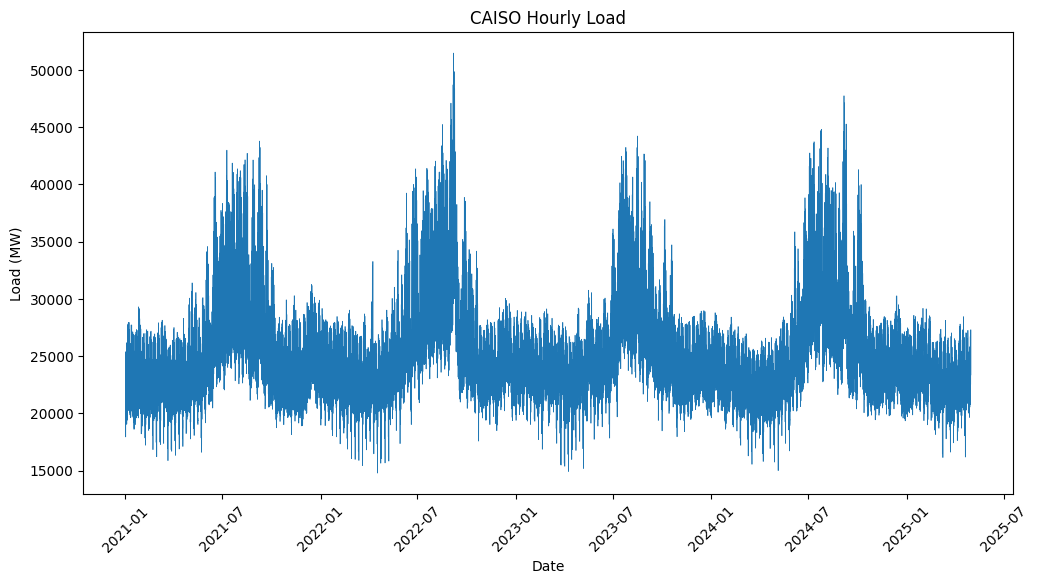

In [5]:
# line plot
plt.figure(figsize=(12, 6))
plt.plot(df["datetime"], df["load"], label="Load", linewidth=0.5)
plt.title("CAISO Hourly Load")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.xticks(rotation=45)
plt.show()

In [6]:
# filter for a specific date range
start_date = "2022-01-01"
predict_date = "2025-02-12"
df_filtered = df[(df["datetime"] >= start_date) & (df["datetime"] < predict_date)]

ground_truth = df[df["datetime"].dt.strftime("%Y-%m-%d") == predict_date]["load"].reset_index(drop=True)

In [7]:
df_filtered.head()

,datetime,load
8760,2022-01-01 00:00:00,22303.67
8761,2022-01-01 01:00:00,21491.08
8762,2022-01-01 02:00:00,21041.72
8763,2022-01-01 03:00:00,20875.96
8764,2022-01-01 04:00:00,20901.42


In [8]:
df_filtered.tail()

,datetime,load
36067,2025-02-11 19:00:00,27952.399986
36068,2025-02-11 20:00:00,27377.637563
36069,2025-02-11 21:00:00,26548.832918
36070,2025-02-11 22:00:00,25033.677535
36071,2025-02-11 23:00:00,23393.151125


In [9]:
# generate features

fm = FeatureManager()
fm.add_generator(LagFeatureGenerator(column="load", lags=[24, 48, 168]))
fm.add_generator(RollingFeatureGenerator(column="load", windows=[24, 168, 720]))
fm.add_generator(CalendarFeatureGenerator())
fm.add_generator(WindowFeatureGenerator(column="load", window_sizes=[24]))

features_df = fm.generate_features(df_filtered)

print(features_df.shape)
print(features_df.columns)
print(features_df.index.max())
# print(features_df.dtypes)

(27120, 63)
Index(['load', 'load_lag_24', 'load_lag_48', 'load_lag_168',
       'load_rolling_mean_24', 'load_rolling_std_24', 'load_rolling_min_24',
       'load_rolling_max_24', 'load_rolling_mean_168', 'load_rolling_std_168',
       'load_rolling_min_168', 'load_rolling_max_168', 'load_rolling_mean_720',
       'load_rolling_std_720', 'load_rolling_min_720', 'load_rolling_max_720',
       'hour', 'dow', 'month', 'day', 'quarter', 'year', 'doy', 'is_weekend',
       'day_before_weekend', 'is_holiday', 'day_before_holiday',
       'day_after_holiday', 'target_dow', 'target_month', 'target_day',
       'target_quarter', 'target_year', 'target_doy', 'target_is_weekend',
       'target_day_before_weekend', 'target_is_holiday',
       'target_day_before_holiday', 'target_day_after_holiday',
       'load_window_24_0', 'load_window_24_1', 'load_window_24_2',
       'load_window_24_3', 'load_window_24_4', 'load_window_24_5',
       'load_window_24_6', 'load_window_24_7', 'load_window_24_8',


In [10]:
windowed_feature_cols = [f"load_window_{24}_{i}" for i in range(0, 24)]
# windowed_feature_cols = []
feature_cols = ["load_lag_24", "load_lag_48", "load_lag_168",
                "load_rolling_mean_24", "load_rolling_min_24", "load_rolling_max_24", "load_rolling_std_24",
                "load_rolling_mean_168", "load_rolling_min_168", "load_rolling_max_168", "load_rolling_std_168",
                "load_rolling_mean_720", "load_rolling_min_720", "load_rolling_max_720", "load_rolling_std_720",
                "hour", "target_month", "target_dow", "target_doy", "target_is_holiday", "target_day_before_holiday", "target_is_weekend", 
                "target_day", "target_quarter", "target_year"] + windowed_feature_cols

# target_doy, target_year

windowed_xgb = XGBForecaster(
    target_col="load",
    feature_cols=feature_cols,
    max_depth=6,
    # n_estimators=300,
)

windowed_xgb.fit(features_df)
# windowed_xgb.fit(features_df_copy)

# prediction = windowed_xgb.predict(horizon=24)

In [11]:
full_features_df = fm.generate_features(df)

In [12]:
full_features_df.tail()

,load,load_lag_24,load_lag_48,load_lag_168,load_rolling_mean_24,load_rolling_std_24,load_rolling_min_24,load_rolling_max_24,load_rolling_mean_168,load_rolling_std_168,...,load_window_24_14,load_window_24_15,load_window_24_16,load_window_24_17,load_window_24_18,load_window_24_19,load_window_24_20,load_window_24_21,load_window_24_22,load_window_24_23
datetime,,,,,,,,,,,,,,,,,,,,,
2025-04-29 19:00:00,26379.503558,25368.102036,23593.766211,26502.408857,23236.777047,1658.067248,20546.747534,26379.503558,23123.549306,1808.035269,...,24580.832309,24138.141217,23882.168972,23158.835372,23150.070212,21712.811733,22191.687977,22257.327481,23739.386558,25168.664266
2025-04-29 20:00:00,26700.857760,25812.602850,24130.206447,26974.422056,23273.787669,1726.562339,20546.747534,26700.857760,23121.920947,1804.666366,...,24138.141217,23882.168972,23158.835372,23150.070212,21712.811733,22191.687977,22257.327481,23739.386558,25168.664266,26379.503558
2025-04-29 21:00:00,26072.787970,25127.366275,23743.741763,26132.854810,23313.180239,1780.630191,20546.747534,26700.857760,23121.563406,1804.072120,...,23882.168972,23158.835372,23150.070212,21712.811733,22191.687977,22257.327481,23739.386558,25168.664266,26379.503558,26700.857760
2025-04-29 22:00:00,24808.101827,23898.632440,22736.224899,24554.304740,23351.074797,1803.166075,20546.747534,26700.857760,23123.074103,1805.384840,...,23158.835372,23150.070212,21712.811733,22191.687977,22257.327481,23739.386558,25168.664266,26379.503558,26700.857760,26072.787970
2025-04-29 23:00:00,23252.531306,22551.064848,21487.856851,23040.133916,23380.302566,1795.302737,20546.747534,26700.857760,23124.338374,1805.400779,...,23150.070212,21712.811733,22191.687977,22257.327481,23739.386558,25168.664266,26379.503558,26700.857760,26072.787970,24808.101827


Fitting and evaluating model for 2025-02-12 00:00:00
Predicting for 2025-02-12 00:00:00 with latest row at 2025-02-11 23:00:00


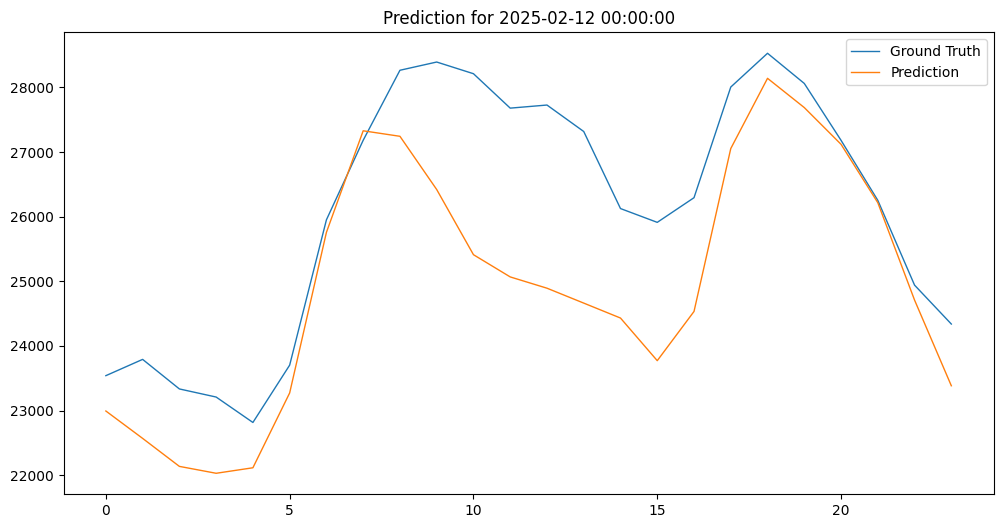

MAPE for 2025-02-12 00:00:00: 0.04767583782705673
MAE for 2025-02-12 00:00:00: 1171.084159421862
RMSE for 2025-02-12 00:00:00: 1482.5245753292759
-------

Fitting and evaluating model for 2025-02-13 00:00:00
Predicting for 2025-02-13 00:00:00 with latest row at 2025-02-12 23:00:00


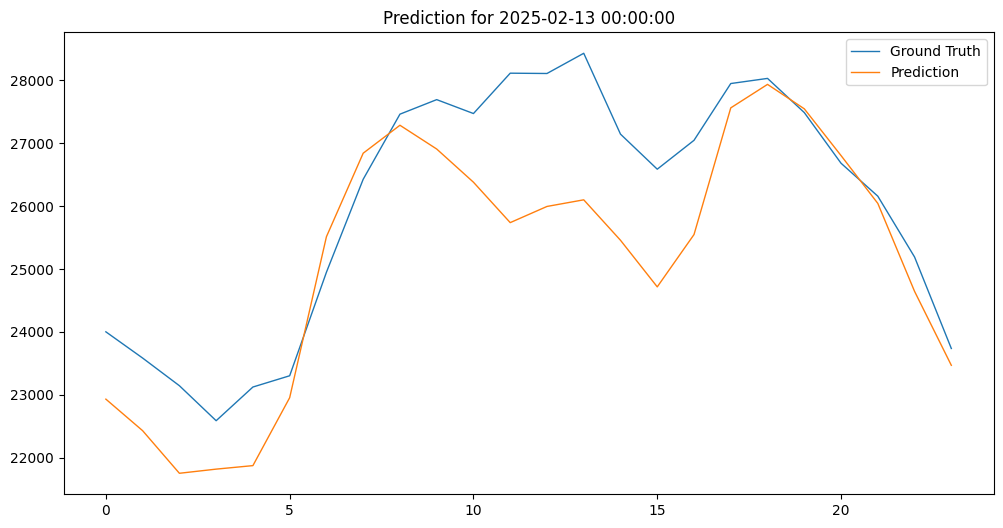

MAPE for 2025-02-13 00:00:00: 0.037893830079018496
MAE for 2025-02-13 00:00:00: 936.3224361093667
RMSE for 2025-02-13 00:00:00: 1184.5335724927836
-------

Fitting and evaluating model for 2025-02-14 00:00:00
Predicting for 2025-02-14 00:00:00 with latest row at 2025-02-13 23:00:00


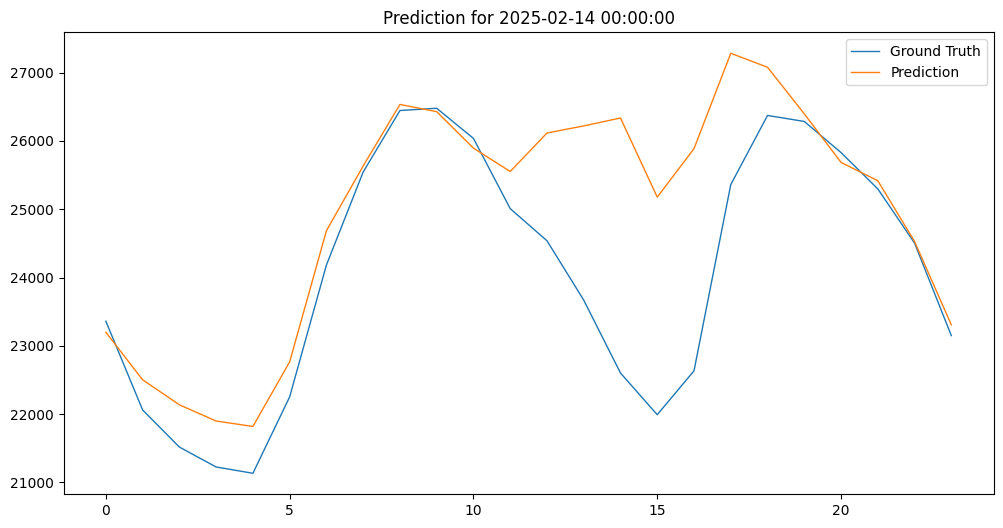

MAPE for 2025-02-14 00:00:00: 0.036060293546259496
MAE for 2025-02-14 00:00:00: 916.3712431562627
RMSE for 2025-02-14 00:00:00: 1447.6393601813375
-------

Fitting and evaluating model for 2025-02-15 00:00:00
Predicting for 2025-02-15 00:00:00 with latest row at 2025-02-14 23:00:00


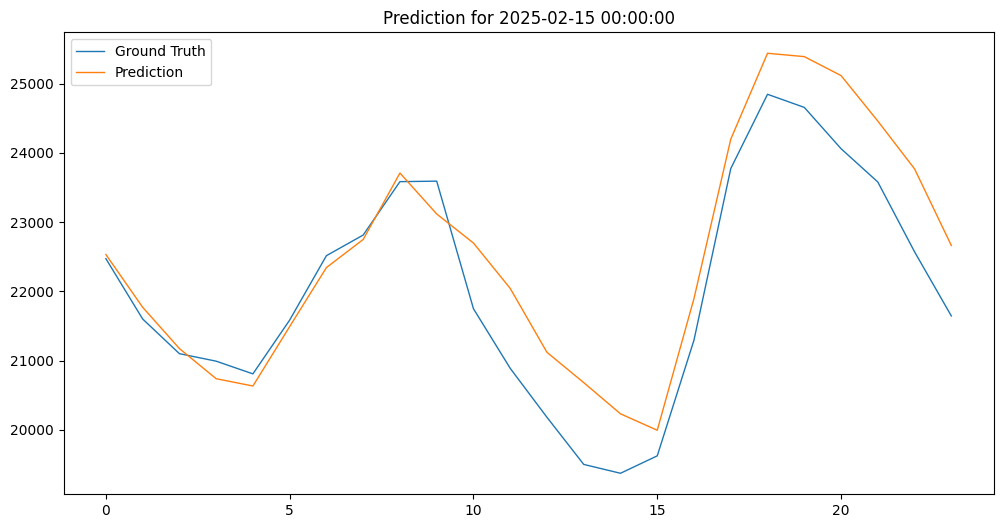

MAPE for 2025-02-15 00:00:00: 0.025090956324249094
MAE for 2025-02-15 00:00:00: 567.0137484531251
RMSE for 2025-02-15 00:00:00: 694.6159372006055
-------

Fitting and evaluating model for 2025-02-16 00:00:00
Predicting for 2025-02-16 00:00:00 with latest row at 2025-02-15 23:00:00


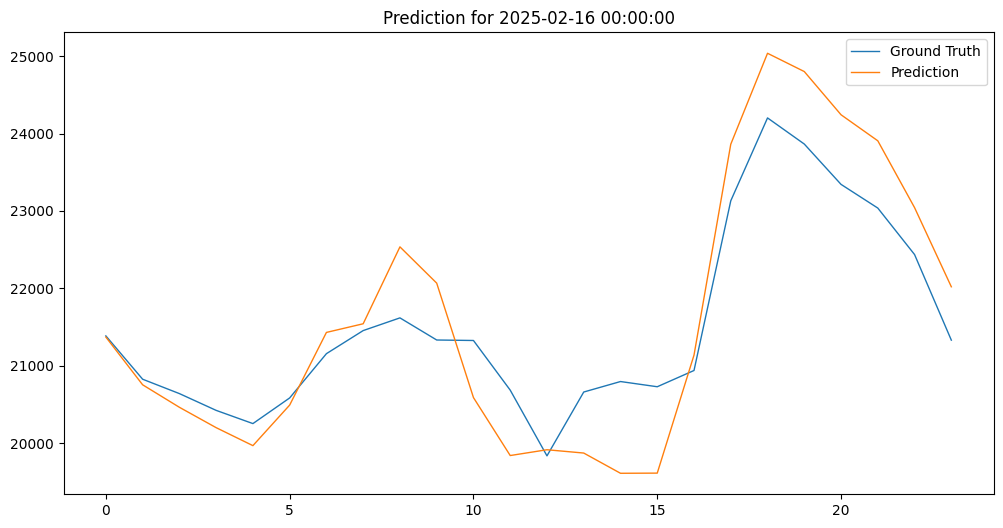

MAPE for 2025-02-16 00:00:00: 0.025629483066008357
MAE for 2025-02-16 00:00:00: 558.1073987249961
RMSE for 2025-02-16 00:00:00: 668.6518487147745
-------

Fitting and evaluating model for 2025-02-17 00:00:00
Predicting for 2025-02-17 00:00:00 with latest row at 2025-02-16 23:00:00


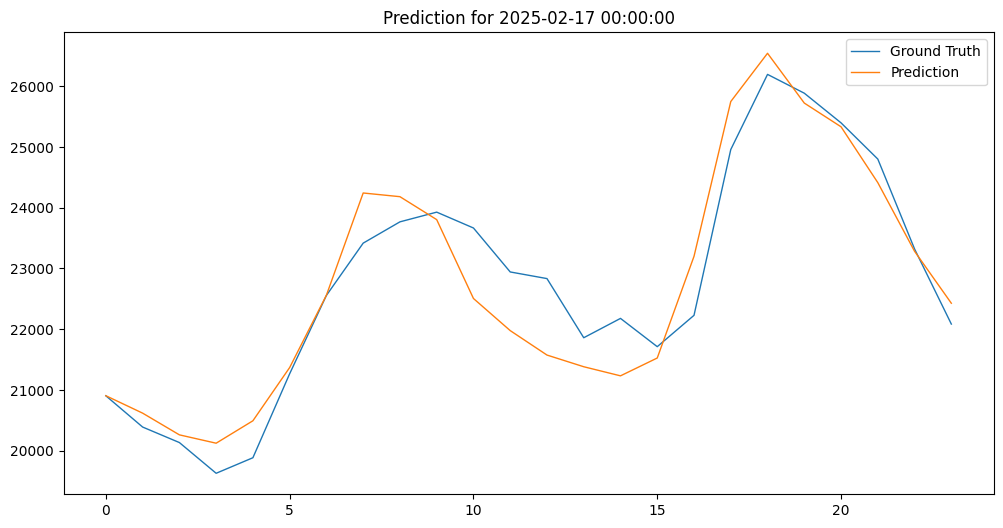

MAPE for 2025-02-17 00:00:00: 0.02040704273411412
MAE for 2025-02-17 00:00:00: 459.58547201457486
RMSE for 2025-02-17 00:00:00: 597.6919584036261
-------

Fitting and evaluating model for 2025-02-18 00:00:00
Predicting for 2025-02-18 00:00:00 with latest row at 2025-02-17 23:00:00


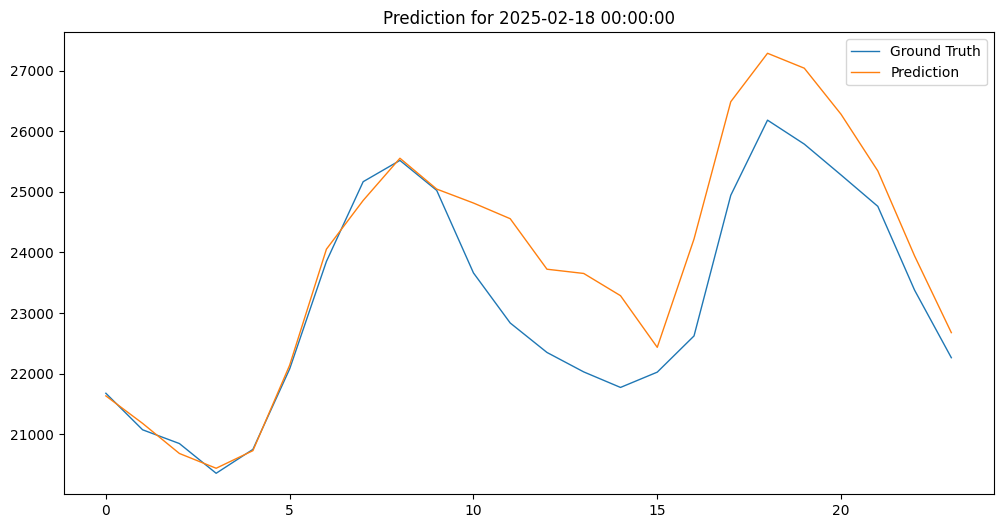

MAPE for 2025-02-18 00:00:00: 0.02860382052470549
MAE for 2025-02-18 00:00:00: 704.5652127614543
RMSE for 2025-02-18 00:00:00: 936.2193725444597
-------

0.03162303772877311


In [13]:
predict_date = "2025-02-12"

predictions = []
mape_list = []

# evaluate predictions and plot for 7 days
for i in range(7):

    # at 00:00 hours
    cur_predict_date = pd.to_datetime(predict_date) + pd.Timedelta(days=i)
    cur_day_before_date = pd.to_datetime(predict_date) + pd.Timedelta(days=i-1)

    # data for the day we are predicting
    predict_df = full_features_df[cur_predict_date:cur_predict_date + pd.Timedelta(hours=23)]
    y_true = predict_df["load"].reset_index(drop=True)
    # print(y_true.tail())
    # print(y_true.shape)

    # filter by predict_date using datetime index
    print(f"Fitting and evaluating model for {cur_predict_date}")

    # simple_xgb = SimpleXGBForecaster(
    #     feature_cols=["load_lag_24", "load_lag_48", "load_lag_168",
    #                 "load_rolling_mean_24", "load_rolling_min_24", "load_rolling_max_24", "load_rolling_std_24",
    #                 "load_rolling_mean_168", "load_rolling_min_168", "load_rolling_max_168", "load_rolling_std_168",
    #                 "load_rolling_mean_720", "load_rolling_min_720", "load_rolling_max_720", "load_rolling_std_720",
    #                 "hour", "month", "dayofweek", "dayofyear", "is_holiday", "day_before_holiday", "is_weekend", 
    #                 "day", "quarter", "year", "hour_is_weekend"],
    #     target_col="load",
    #     # n_estimators=300,
    #     max_depth=6,
    # )
    # simple_xgb.fit(cur_features_df)
    # predict_features_df = fm.generate_features(predict_df)

    # take latest row as pandas series and df for windowed version
    day_before_df = full_features_df[cur_day_before_date:cur_day_before_date + pd.Timedelta(hours=23)]
    latest_row = day_before_df.iloc[-1]
    latest_datetime = day_before_df.index[-1]
    # latest_day_df = day_before_df[latest_datetime - pd.Timedelta(hours=23):latest_datetime]

    # check temporal alignment
    print(f"Predicting for {cur_predict_date} with latest row at {latest_datetime}")

    # check if target_dow matches the predict dow
    if latest_row["target_dow"] != cur_predict_date.dayofweek:
        print(f"Warning: target_dow {latest_row['target_dow']} does not match predict dow {cur_predict_date.dayofweek}")
    
    # inference
    # y_pred = simple_xgb.predict(horizon=24, external_features=latest_row)
    y_pred = windowed_xgb.predict(horizon=24, input_features=latest_row)

    predictions.append(y_pred)

    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label="Ground Truth", linewidth=1)
    plt.plot(y_pred, label="Prediction", linewidth=1)
    plt.title(f"Prediction for {cur_predict_date}")
    plt.legend()
    plt.show()

    mape = mean_absolute_percentage_error(y_pred, y_true)
    mae = mean_absolute_error(y_pred, y_true)
    rmse = root_mean_squared_error(y_pred, y_true)

    mape_list.append(mape)

    print(f"MAPE for {cur_predict_date}: {mape}")
    print(f"MAE for {cur_predict_date}: {mae}")
    print(f"RMSE for {cur_predict_date}: {rmse}")
    print("-------\n")

print(np.mean(mape_list))

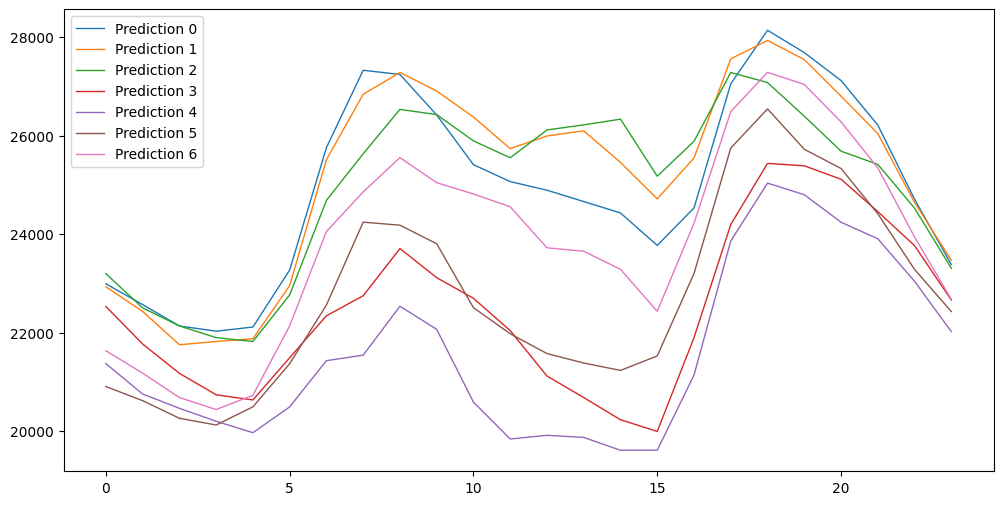

In [14]:
# predictions.append(y_pred)

plt.figure(figsize=(12, 6))
for i, y_pred in enumerate(predictions):
    # plt.plot(y_true, label="Ground Truth", linewidth=1)
    plt.plot(y_pred, label=f"Prediction {i}", linewidth=1)

# plt.title(f"Prediction for {cur_predict_date}")
plt.legend()
plt.show()

## Walk Forward Evaluation

In [15]:
windowed_feature_cols = [f"load_window_{24}_{i}" for i in range(0, 24)]
# windowed_feature_cols = []
feature_cols = ["load_lag_24", "load_lag_48", "load_lag_168",
                "load_rolling_mean_24", "load_rolling_min_24", "load_rolling_max_24", "load_rolling_std_24",
                "load_rolling_mean_168", "load_rolling_min_168", "load_rolling_max_168", "load_rolling_std_168",
                "load_rolling_mean_720", "load_rolling_min_720", "load_rolling_max_720", "load_rolling_std_720",
                "hour", "target_month", "target_dow", "target_doy", "target_is_holiday", "target_day_before_holiday", "target_is_weekend", 
                "target_day", "target_quarter", "target_year"] + windowed_feature_cols

In [ ]:
first_test_date = "2024-01-01"
last_test_date = "2024-12-31"
test_days = (pd.to_datetime(last_test_date) - pd.to_datetime(first_test_date)).days
train_days = 730

predictions = []
mape_list = []
mae_list = []
rmse_list = []

model = None

# evaluate predictions and plot for 7 days
for i in range(test_days):

    # at 00:00 hours
    cur_predict_date = pd.to_datetime(first_test_date) + pd.Timedelta(days=i)
    cur_day_before_date = pd.to_datetime(first_test_date) + pd.Timedelta(days=i-1)

    # whether or not to train the model
    if i % 7 == 0:
        print(f"Training model for day {i} at {cur_predict_date}")

        train_start_date = cur_day_before_date - pd.Timedelta(days=train_days)
        train_df = full_features_df[train_start_date:cur_day_before_date + pd.Timedelta(days=1) - pd.Timedelta(hours=1)]

        model = XGBForecaster(
            target_col="load",
            feature_cols=feature_cols,
            max_depth=6,
        )
        
        model.fit(train_df)
        

    # data for the day we are predicting
    predict_df = full_features_df[cur_predict_date:cur_predict_date + pd.Timedelta(days=1) - pd.Timedelta(hours=1)]
    y_true = predict_df["load"].reset_index(drop=True)

    # take latest row as pandas series and df for windowed version
    day_before_df = full_features_df[cur_day_before_date:cur_day_before_date + pd.Timedelta(days=1) - pd.Timedelta(hours=1)]
    latest_row = day_before_df.iloc[-1]

    # check if target_dow matches the predict dow
    if latest_row["target_dow"] != cur_predict_date.dayofweek:
        # print(cur_day_before_date + pd.Timedelta(days=1) - pd.Timedelta(hours=1))
        # print(cur_predict_date)
        # print(day_before_df.head().index)
        # print(day_before_df.tail().index)
        print(f"Warning: target_dow {latest_row['target_dow']} does not match predict dow {cur_predict_date.dayofweek}")
    
    # inference
    y_pred = model.predict(horizon=24, input_features=latest_row)

    # just skip daylight saving time days
    # TODO: this is a hack, need to handle it properly
    if cur_predict_date.month in [3, 11] and (day_before_df.shape[0] != 24 or len(y_true) != 24):
        # y_pred = y_pred[:y_true.shape[0]]
        print(f"Warning: Skipping prediction for {cur_predict_date} due to unsupported DST.")
        continue

    predictions.append(y_pred)

    mape = mean_absolute_percentage_error(y_pred, y_true)
    rmse = root_mean_squared_error(y_pred, y_true)
    mae = mean_absolute_error(y_pred, y_true)

    mape_list.append(mape)
    rmse_list.append(rmse)
    mae_list.append(mae)

print(len(mape_list))

Training model for day 0 at 2024-01-01 00:00:00
Training model for day 7 at 2024-01-08 00:00:00
Training model for day 14 at 2024-01-15 00:00:00


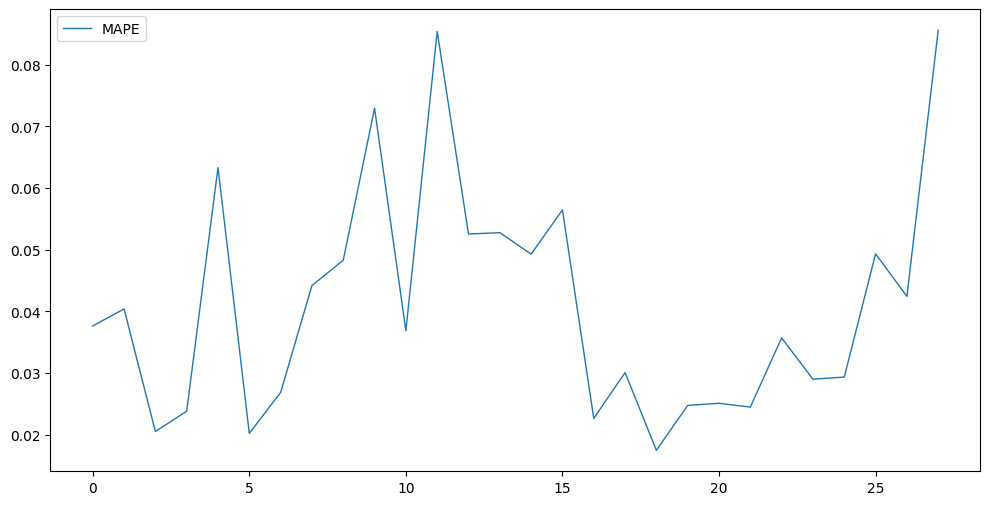

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(mape_list, label=f"MAPE", linewidth=1)

# plt.title(f"Prediction for {cur_predict_date}")
plt.legend()
plt.show()